### Image classification

### VGG-19

In [56]:
#Firstly, let us import the required packages:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import os
import cv2
import glob
import matplotlib.pyplot as plt

In [57]:
# Create path for hc
path = os.getcwd()
dirname = os.path.dirname(path)

In [58]:
# re-size all the images(vgg19 expect only 224x224)
IMAGE_SIZE = [224, 224]

In [54]:
train_path = dirname + "/data/all_deg/train"
test_path = dirname + "/data/all_deg/test"
val_path = dirname + "/data/all_deg/val"

In [52]:
x_train=[]
for folder in os.listdir(train_path):
    if folder == '.DS_Store':
        continue
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

x_test=[]
for folder in os.listdir(test_path):
    if folder == '.DS_Store':
        continue
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

x_val=[]
for folder in os.listdir(val_path):
    if folder == '.DS_Store':
        continue
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)

error: OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [12]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [13]:
# label computing
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 39 images belonging to 2 classes.
Found 12 images belonging to 2 classes.
Found 9 images belonging to 2 classes.


In [15]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [16]:
training_set.class_indices

{'hc': 0, 'pd': 1}

In [17]:
train_y.shape,test_y.shape,val_y.shape

((39,), (12,), (9,))

### Model building

In [18]:

# re-size all the images to this
IMAGE_SIZE = [224, 224]
## Loading VGG16 model
vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=IMAGE_SIZE + [3])#pooling='avg')

# don't train existing weights
for layer in vgg19.layers:
    layer.trainable = False


# New Flatten layer after the last pooling layer in VGG19 model and define new classifier
flat_l = Flatten()(vgg19.output)
# class_l = Dense(1024, activation='relu')(flat_l)
# drop_out = Dropout(0.5)(class_l)
prediction = Dense(2, activation='softmax')(flat_l) # sigmoid is for binary classification


# # create a model object
model = Model(inputs=vgg19.input, outputs=prediction)
# # view the structure of the model
model.summary()

2022-03-18 13:31:01.591619: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-18 13:31:01.592129: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                  

In [19]:
# tell the model what cost and optimization method to use

BATCH_SIZE = 32
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

# train_gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
#                          height_shift_range=0.08, zoom_range=0.08)
# train_generator = train_gen.flow(train_x, train_y, batch_size=BATCH_SIZE)

es = EarlyStopping(monitor='val_loss', mode='min', patience=5,  verbose=1)

history = model.fit( train_x,train_y, validation_data=(val_x,val_y),callbacks=[es],
                    epochs=10, batch_size=BATCH_SIZE,shuffle=True)

# val_gen = ImageDataGenerator()
# val_generator = val_gen.flow(val_x, val_y, batch_size=BATCH_SIZE)

2022-03-18 13:31:07.660812: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-03-18 13:31:07.961691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 1.0440 - accuracy: 0.5641

2022-03-18 13:31:10.341315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 1s/step - loss: 1.0440 - accuracy: 0.5641 - val_loss: 4.4242 - val_accuracy: 0.5556
Epoch 2/10
2/2 [==============================] - 3s 946ms/step - loss: 3.8853 - accuracy: 0.5641 - val_loss: 1.9934 - val_accuracy: 0.5556
Epoch 3/10
2/2 [==============================] - 2s 965ms/step - loss: 1.0866 - accuracy: 0.6410 - val_loss: 2.3164 - val_accuracy: 0.4444
Epoch 4/10
2/2 [==============================] - 2s 800ms/step - loss: 1.8362 - accuracy: 0.4359 - val_loss: 1.5520 - val_accuracy: 0.4444
Epoch 5/10
2/2 [==============================] - 2s 809ms/step - loss: 0.8490 - accuracy: 0.6923 - val_loss: 2.0012 - val_accuracy: 0.5556
Epoch 6/10
2/2 [==============================] - 3s 870ms/step - loss: 0.8706 - accuracy: 0.5897 - val_loss: 2.8568 - val_accuracy: 0.5556
Epoch 7/10
2/2 [==============================] - 2s 820ms/step - loss: 1.2896 - accuracy: 0.5641 - val_loss: 1.8330 - val_accuracy: 0.5556
Epoch 8/10
2/2 [==================

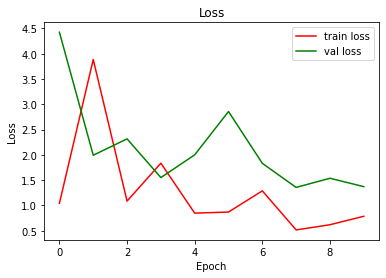

In [20]:
# loss
plt.plot(history.history['loss'],label='train loss',color='r')
plt.plot(history.history['val_loss'],label='val loss',color='g')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

#plt.savefig('vgg19-loss.png')
plt.show()

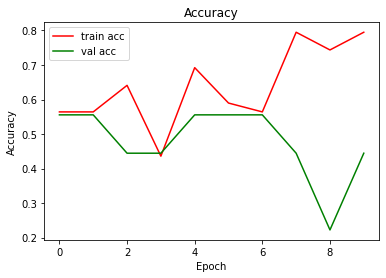

In [21]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc',color='r')
plt.plot(history.history['val_accuracy'], label='val acc',color='g')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#plt.savefig('vgg19-acc-rps-1.png',dpi=300)
plt.show()

In [22]:
#Evaluation
model.evaluate(test_x,test_y,batch_size=32)
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

# Accuracy
accuracy = accuracy_score(y_pred,test_y)
print('The accuracy score of the model:',accuracy)

# classification report
print(classification_report(y_pred,test_y))

1/1 [==============================] - 1s 789ms/step - loss: 1.1753 - accuracy: 0.5000


2022-03-18 13:31:43.825641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


The accuracy score of the model: 0.5
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.43      0.60      0.50         5

    accuracy                           0.50        12
   macro avg       0.51      0.51      0.50        12
weighted avg       0.53      0.50      0.50        12



In [133]:
confusion = confusion_matrix(y_pred,test_y)
print(confusion)

[[ 3  0]
 [23 32]]


In [134]:
#confusion matrix
confusion = confusion_matrix(y_pred,test_y)
print(confusion)

#  Sensitivity 
TP = confusion[1,1] # true positives
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # False positives
FN = confusion[1,0] # false negatives

sensitivity = TP/float(TP+FN)
print(sensitivity)

# Specificity
specificity = TN/float(TN+FP)
print(specificity)

[[ 3  0]
 [23 32]]
0.5818181818181818
1.0


### AUC-Score

In [135]:
auc_score = roc_auc_score(test_y, y_pred)
fpr , tpr , thresholds = roc_curve (test_y, y_pred)
print(auc_score)


0.5576923076923077


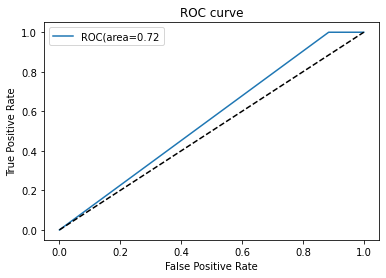

In [136]:
def plot_roc_curve(fpr,tpr): 
  random_probs = [0 for i in range(len(test_y))]
  p_fpr, p_tpr, _ = roc_curve(test_y, random_probs, pos_label=1)
  plt.plot(fpr,tpr,label='ROC(area=0.72')
  plt.plot(p_fpr, p_tpr,'--',color='black') 
  plt.axis([-0.05,1.05,-0.05,1.05]) 
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.legend()
  plt.show()    
  
plot_roc_curve (fpr,tpr)
#plt.savefig('roc-vgg19.png',dpi=300)

## VGG16

In [43]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# re-size all the images to this
IMAGE_SIZE = [224, 224]
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=IMAGE_SIZE + [3])

# don't train existing weights
for layer in base_model.layers:
    layer.trainable = False


# our layers - you can add more if you want
last_l = Flatten()(base_model.output)
last_l = Dropout(0.5)(last_l)
prediction = Dense(2, activation='softmax')(last_l) 


# # create a model object
model = Model(inputs=base_model.input, outputs=prediction)
# # view the structure of the model
model.summary()




Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [44]:
BATCH_SIZE = 32
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

train_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
train_generator = train_gen.flow(train_x, train_y, batch_size=BATCH_SIZE)

# val_gen = ImageDataGenerator()
# val_generator = val_gen.flow(val_x, val_y, batch_size=BATCH_SIZE)

In [45]:
#es = EarlyStopping(monitor='val_loss', mode='min', patience=5,  verbose=1)

vgg_16 = model.fit(
  train_generator,
  validation_data=(val_x,val_y),
  epochs=10,
  #callbacks=[es],
  batch_size=BATCH_SIZE,shuffle=True,verbose=1)

Epoch 1/10


2022-03-14 15:35:06.446069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 1.0688 - accuracy: 0.4652

2022-03-14 15:35:14.498203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 10s 2s/step - loss: 1.0688 - accuracy: 0.4652 - val_loss: 0.8112 - val_accuracy: 0.5532
Epoch 2/10
6/6 [==============================] - 9s 2s/step - loss: 1.0064 - accuracy: 0.4706 - val_loss: 0.8416 - val_accuracy: 0.5532
Epoch 3/10
6/6 [==============================] - 9s 2s/step - loss: 0.9245 - accuracy: 0.5508 - val_loss: 0.7497 - val_accuracy: 0.5532
Epoch 4/10
6/6 [==============================] - 9s 1s/step - loss: 1.0161 - accuracy: 0.4652 - val_loss: 0.7812 - val_accuracy: 0.5532
Epoch 5/10
6/6 [==============================] - 9s 1s/step - loss: 1.0303 - accuracy: 0.5241 - val_loss: 0.7983 - val_accuracy: 0.5532
Epoch 6/10
6/6 [==============================] - 9s 1s/step - loss: 1.1150 - accuracy: 0.5187 - val_loss: 0.8082 - val_accuracy: 0.5532
Epoch 7/10
6/6 [==============================] - 9s 1s/step - loss: 0.9145 - accuracy: 0.5348 - val_loss: 0.7676 - val_accuracy: 0.5532
Epoch 8/10
6/6 [==============================] - 9

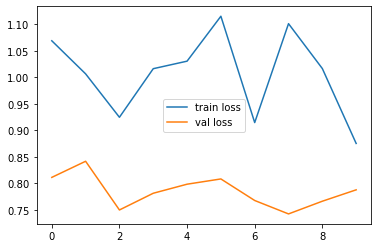

In [46]:
# loss
plt.plot(vgg_16.history['loss'], label='train loss')
plt.plot(vgg_16.history['val_loss'], label='val loss')
plt.legend()
#plt.savefig('vgg-loss-rps-1.png')
plt.show()

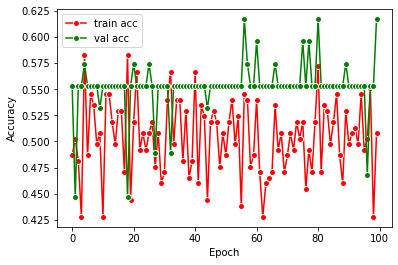

In [26]:
plt.plot(vgg_16.history['accuracy'],'o-',markeredgecolor='w', label='train acc',color='r')
plt.plot(vgg_16.history['val_accuracy'],'o-',markeredgecolor='w', label='val acc',color='g')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('vgg_16.png',dpi=300)
plt.show()

In [27]:
model.evaluate(test_x,test_y,batch_size=32)

2/2 [==============================] - 2s 1s/step - loss: 0.6995 - accuracy: 0.5000


[0.6994566917419434, 0.5]

In [28]:
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

2022-03-14 15:27:02.421313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [29]:
accuracy_score(y_pred,test_y)

0.5

In [30]:
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.12      0.33      0.17         9
           1       0.81      0.53      0.64        49

    accuracy                           0.50        58
   macro avg       0.46      0.43      0.41        58
weighted avg       0.70      0.50      0.57        58



In [31]:
confusion = confusion_matrix(y_pred,test_y)
print(confusion)

[[ 3  6]
 [23 26]]


In [32]:
# Sensitivity 
TP = confusion[1,1] # true positives
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # False positives
FN = confusion[1,0] # false negatives

sensitivity = TP/float(TP+FN)
print(sensitivity)

# Specificity
specificity = TN/float(TN+FP)
print(specificity)

0.5306122448979592
0.3333333333333333


In [33]:
auc_score = roc_auc_score(test_y, y_pred)
fpr , tpr , thresholds = roc_curve (test_y, y_pred)
print(auc_score)

0.4639423076923077


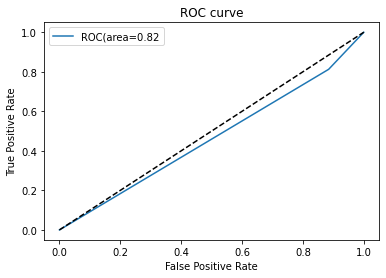

<Figure size 432x288 with 0 Axes>

In [34]:
def plot_roc_curve(fpr,tpr): 
  random_probs = [0 for i in range(len(test_y))]
  p_fpr, p_tpr, _ = roc_curve(test_y, random_probs, pos_label=1)
  plt.plot(fpr,tpr,label='ROC(area=0.82')
  plt.plot(p_fpr, p_tpr,'--',color='black') 
  plt.axis([-0.05,1.05,-0.05,1.05]) 
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.legend()
  plt.show()    
  
plot_roc_curve (fpr,tpr)
plt.savefig('roc-vgg16.png',dpi=300)

### Inception-v3

In [32]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# re-size all the images to this
IMAGE_SIZE = [224, 224]
## Loading VGG16 model
base_inception = InceptionV3(weights="imagenet", include_top=False, input_shape=IMAGE_SIZE + [3])

# don't train existing weights
for layer in base_inception.layers:
    layer.trainable = False


# our layers - you can add more if you want
last_l = Flatten()(base_inception.output)
prediction = Dense(3, activation='softmax')(last_l) 


# # create a model object
model = Model(inputs=base_inception.input, outputs=prediction)
# # view the structure of the model
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [34]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,  verbose=1)

inception = model.fit(train_x,train_y, epochs=10, validation_data=(val_x,val_y), batch_size=32, callbacks=[es],shuffle=True)

Epoch 1/10


2022-03-14 02:14:27.521068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 5.3698 - accuracy: 0.5080

2022-03-14 02:14:32.897064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 9s 1s/step - loss: 5.3698 - accuracy: 0.5080 - val_loss: 2.1759 - val_accuracy: 0.6383
Epoch 2/10
6/6 [==============================] - 4s 721ms/step - loss: 4.4378 - accuracy: 0.5722 - val_loss: 4.4141 - val_accuracy: 0.5532
Epoch 3/10
6/6 [==============================] - 4s 649ms/step - loss: 3.1704 - accuracy: 0.6043 - val_loss: 3.8369 - val_accuracy: 0.4255
Epoch 4/10
6/6 [==============================] - 3s 530ms/step - loss: 1.8410 - accuracy: 0.6417 - val_loss: 1.9356 - val_accuracy: 0.5319
Epoch 5/10
6/6 [==============================] - 3s 504ms/step - loss: 1.0085 - accuracy: 0.7112 - val_loss: 1.7315 - val_accuracy: 0.6170
Epoch 6/10
6/6 [==============================] - 3s 589ms/step - loss: 0.6664 - accuracy: 0.7273 - val_loss: 2.3634 - val_accuracy: 0.6170
Epoch 7/10
6/6 [==============================] - 3s 497ms/step - loss: 0.3506 - accuracy: 0.8503 - val_loss: 2.0042 - val_accuracy: 0.6170
Epoch 8/10
6/6 [==================

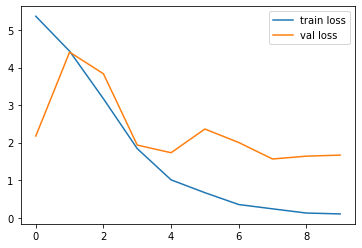

In [35]:
# loss
plt.plot(inception.history['loss'], label='train loss')
plt.plot(inception.history['val_loss'], label='val loss')
plt.legend()
#plt.savefig('vgg-loss-rps-1.png')
plt.show()

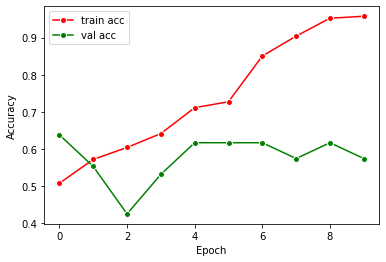

In [36]:
plt.plot(inception.history['accuracy'],'o-',markeredgecolor='w', label='train acc',color='r')
plt.plot(inception.history['val_accuracy'],'o-',markeredgecolor='w', label='val acc',color='g')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#plt.savefig('inception.png',dpi=300)
plt.show()

In [37]:
model.evaluate(test_x,test_y,batch_size=32)

2/2 [==============================] - 2s 1s/step - loss: 1.4902 - accuracy: 0.4655


[1.4902396202087402, 0.4655172526836395]

In [38]:
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

2022-03-14 02:15:43.704858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [39]:
accuracy_score(y_pred,test_y)

0.46551724137931033

In [40]:
print(classification_report(y_pred,test_y))



              precision    recall  f1-score   support

           0       0.15      0.31      0.21        13
           1       0.72      0.51      0.60        45

    accuracy                           0.47        58
   macro avg       0.44      0.41      0.40        58
weighted avg       0.59      0.47      0.51        58



In [126]:
confusion = confusion_matrix(y_pred,test_y)
print(confusion)

[[3 1]
 [2 6]]


In [127]:
# Sensitivity 
TP = confusion[1,1] # true positives
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # False positives
FN = confusion[1,0] # false negatives

sensitivity = TP/float(TP+FN)
print(sensitivity)

# Specificity
specificity = TN/float(TN+FP)
print(specificity)

0.75
0.75


0.7285714285714286


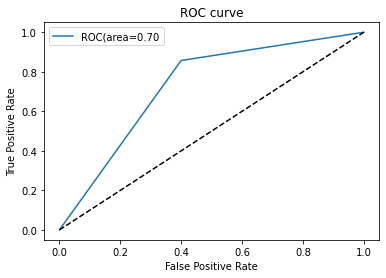

<Figure size 432x288 with 0 Axes>

In [128]:
auc_score = roc_auc_score(test_y, y_pred)
fpr , tpr , thresholds = roc_curve (test_y, y_pred)
print(auc_score)
def plot_roc_curve(fpr,tpr): 
  random_probs = [0 for i in range(len(test_y))]
  p_fpr, p_tpr, _ = roc_curve(test_y, random_probs, pos_label=1)
  plt.plot(fpr,tpr,label='ROC(area=0.70')
  plt.plot(p_fpr, p_tpr,'--',color='black') 
  plt.axis([-0.05,1.05,-0.05,1.05]) 
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.legend()
  plt.show()    
  
plot_roc_curve (fpr,tpr)
plt.savefig('roc-inception.png',dpi=300)

### Resnet50

In [94]:
from tensorflow.keras.applications.resnet50 import ResNet50

# re-size all the images to this
IMAGE_SIZE = [224, 224]
## Loading VGG16 model
base_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=IMAGE_SIZE + [3])

# don't train existing weights
for layer in base_resnet.layers:
    layer.trainable = False


# our layers - you can add more if you want
last_l = Flatten()(base_resnet.output)
prediction = Dense(3, activation='softmax')(last_l) 


# # create a model object
model = Model(inputs=base_resnet.input, outputs=prediction)
# # view the structure of the model
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [96]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [97]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,  verbose=1)

resnet = model.fit(train_x,train_y, epochs=10, validation_data=(val_x,val_y), batch_size=32, callbacks=[es],shuffle=True)

Epoch 1/10


2022-03-11 14:26:22.292741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - ETA: 0s - loss: 3.0162 - accuracy: 0.5385

2022-03-11 14:26:24.680192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 4s 2s/step - loss: 3.0162 - accuracy: 0.5385 - val_loss: 5.9168 - val_accuracy: 0.4444
Epoch 2/10
2/2 [==============================] - 1s 479ms/step - loss: 4.0435 - accuracy: 0.6154 - val_loss: 8.4047 - val_accuracy: 0.5556
Epoch 3/10
2/2 [==============================] - 1s 447ms/step - loss: 8.5400 - accuracy: 0.5641 - val_loss: 8.7174 - val_accuracy: 0.5556
Epoch 4/10
2/2 [==============================] - 1s 554ms/step - loss: 8.3406 - accuracy: 0.5641 - val_loss: 1.8535 - val_accuracy: 0.5556
Epoch 5/10
2/2 [==============================] - 1s 432ms/step - loss: 1.7381 - accuracy: 0.5897 - val_loss: 6.3198 - val_accuracy: 0.4444
Epoch 6/10
2/2 [==============================] - 1s 415ms/step - loss: 6.1632 - accuracy: 0.4359 - val_loss: 3.6253 - val_accuracy: 0.4444
Epoch 7/10
2/2 [==============================] - 1s 421ms/step - loss: 2.9381 - accuracy: 0.4615 - val_loss: 3.1062 - val_accuracy: 0.5556
Epoch 8/10
2/2 [==================

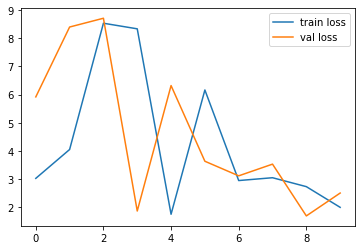

In [98]:
# loss
plt.plot(resnet.history['loss'], label='train loss')
plt.plot(resnet.history['val_loss'], label='val loss')
plt.legend()
#plt.savefig('vgg-loss-rps-1.png')
plt.show()

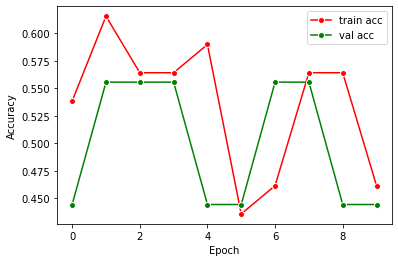

In [99]:
plt.plot(resnet.history['accuracy'],'o-',markeredgecolor='w', label='train acc',color='r')
plt.plot(resnet.history['val_accuracy'],'o-',markeredgecolor='w', label='val acc',color='g')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('resnet.png',dpi=300)
plt.show()

In [43]:
model.evaluate(test_x,test_y,batch_size=32)

1/1 [==============================] - 1s 1s/step - loss: 3.8531 - accuracy: 0.5833


[3.853069305419922, 0.5833333730697632]

In [44]:
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

2022-03-10 20:53:25.397684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [45]:
accuracy_score(y_pred,test_y)

0.5833333333333334

In [46]:
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.58      0.74        12

    accuracy                           0.58        12
   macro avg       0.50      0.29      0.37        12
weighted avg       1.00      0.58      0.74        12



/Users/zaw/miniforge3/envs/ds/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zaw/miniforge3/envs/ds/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zaw/miniforge3/envs/ds/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
